In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

# Path to your zip file
zip_path = '/content/drive/MyDrive/GroupO_DataSet.zip'
extract_dir = 'GroupO_DataSet'  # Folder where all extracted folders will be stored

# Create a main extraction directory
os.makedirs(extract_dir, exist_ok=True)

# Extract each main folder separately
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        # Extract files while preserving folder structure
        zip_ref.extract(file, extract_dir)

print("Extraction complete. Check the folder:", extract_dir)


Extraction complete. Check the folder: GroupO_DataSet


In [3]:
# Importing necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import cv2

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
dataset = torchvision.datasets.ImageFolder(root='/content/GroupO_DataSet/RSI-CB/', transform=data_transforms)

In [7]:
train_size = int(0.7 * len(dataset))
valid_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

In [8]:
batch_size = 64
learning_rate = 0.001
num_epochs = 40

# Print the configuration
print(f"Training with batch size: {batch_size}, learning rate: {learning_rate}, and epochs: {num_epochs}")


Training with batch size: 64, learning rate: 0.001, and epochs: 40


In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
model = models.densenet121(pretrained=True)
num_classes = 5
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 187MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
loss_during_epoch = []
accuracy_during_epoch = []

In [13]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, target_class=None):
        output = self.model(input_tensor)

        if target_class is None:
            target_class = torch.argmax(output, dim=1)

        self.model.zero_grad()
        output[:, target_class].backward(retain_graph=True)

        gradients = self.gradients[0].cpu().data.numpy()
        activations = self.activations[0].cpu().data.numpy()

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cam / np.max(cam)
        return cam

def visualize_gradcam(cam, original_image, alpha=0.5):
    cam = cv2.resize(cam, (original_image.shape[1], original_image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + np.float32(original_image / 255)
    overlay = overlay / np.max(overlay)
    return np.uint8(255 * overlay)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 1, Loss: 0.2070540776597215, Accuracy: 93.01%, Validation Loss: 0.1383136555439595, Validation Accuracy: 95.46%, Running time: 201.90489983558655


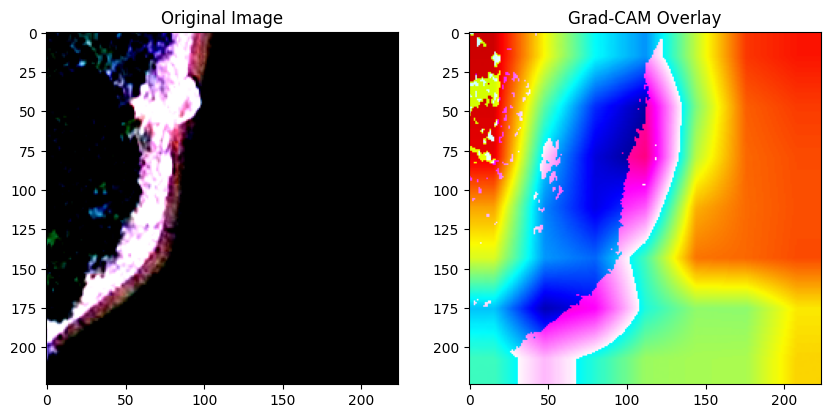

Epoch 2, Loss: 0.08928597249993772, Accuracy: 97.08%, Validation Loss: 0.22214695828204806, Validation Accuracy: 92.73%, Running time: 199.78090739250183


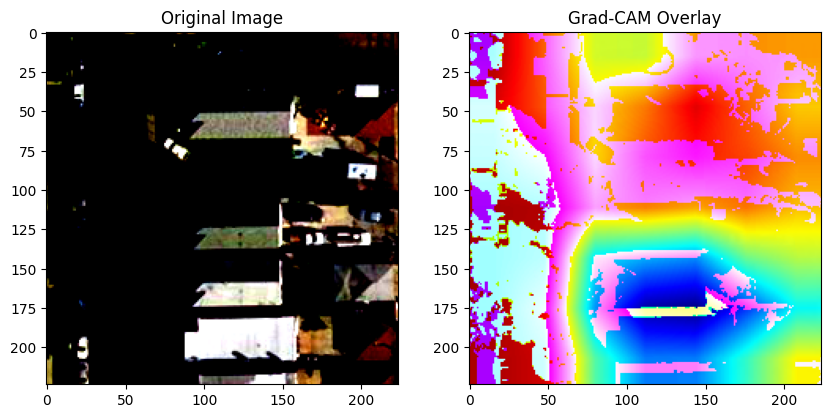

Epoch 3, Loss: 0.06963646698347999, Accuracy: 97.79%, Validation Loss: 0.11656168899075552, Validation Accuracy: 95.63%, Running time: 199.46334195137024


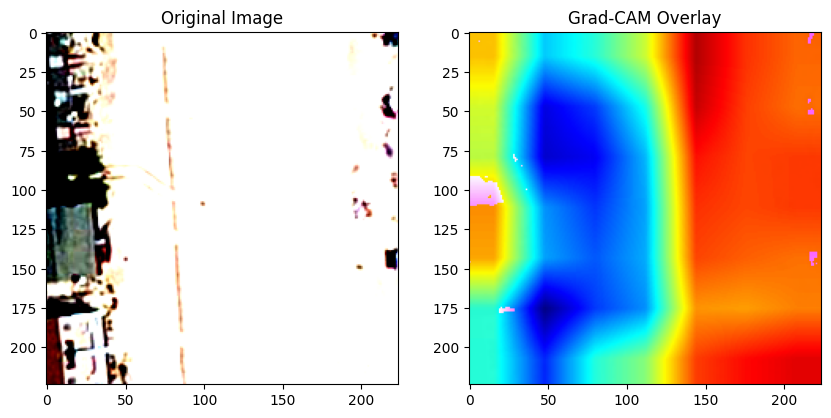

Epoch 4, Loss: 0.07182911708870363, Accuracy: 97.73%, Validation Loss: 0.08567034489842075, Validation Accuracy: 96.67%, Running time: 198.71310210227966


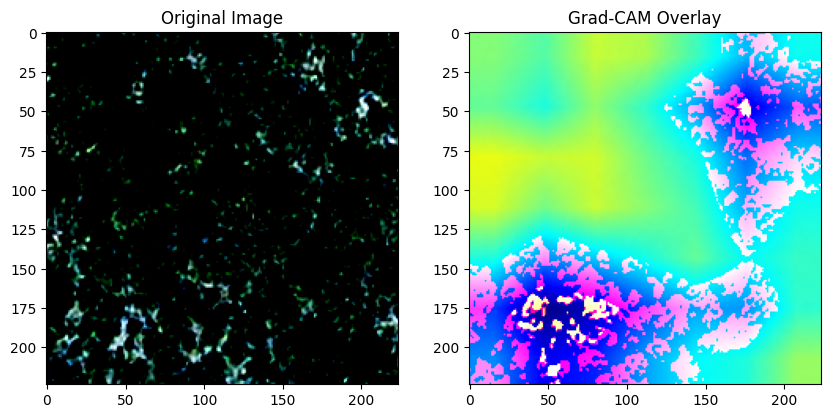

Epoch 5, Loss: 0.07336028165474244, Accuracy: 97.59%, Validation Loss: 0.07846302992777165, Validation Accuracy: 97.03%, Running time: 199.04318714141846


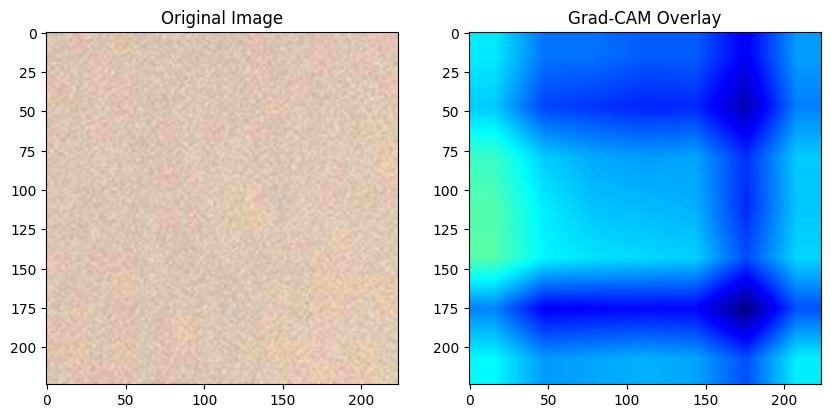

Epoch 6, Loss: 0.03506191690035116, Accuracy: 98.85%, Validation Loss: 0.047233110256704756, Validation Accuracy: 98.48%, Running time: 199.41480922698975


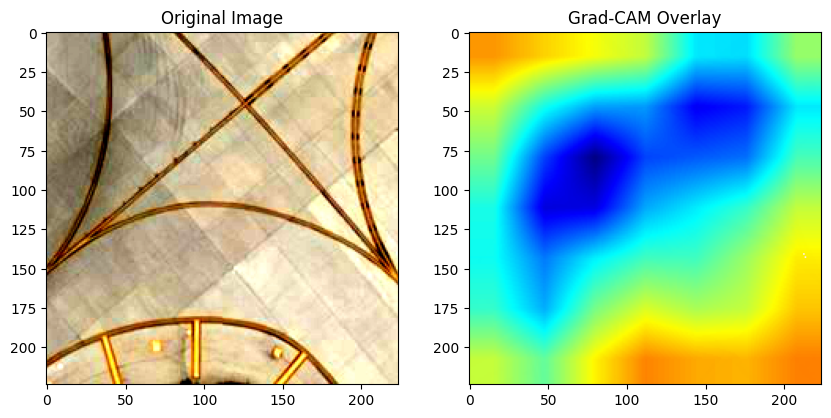

Epoch 7, Loss: 0.03543824994421536, Accuracy: 98.85%, Validation Loss: 0.048814509012806935, Validation Accuracy: 98.24%, Running time: 199.57908129692078


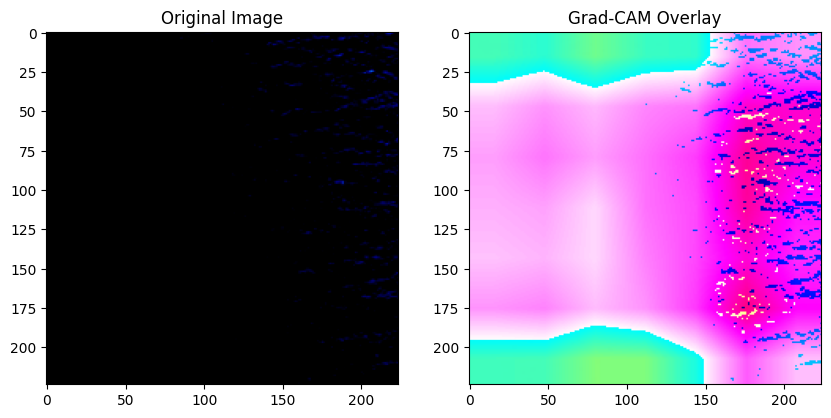

Epoch 8, Loss: 0.04439228964320412, Accuracy: 98.58%, Validation Loss: 0.032620695080064856, Validation Accuracy: 98.79%, Running time: 199.2583520412445


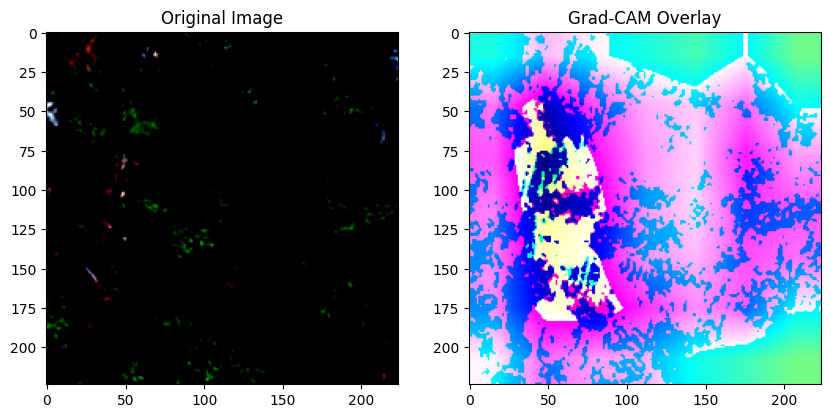

Epoch 9, Loss: 0.028090868801008546, Accuracy: 99.12%, Validation Loss: 0.3835331853479147, Validation Accuracy: 91.73%, Running time: 199.59271836280823


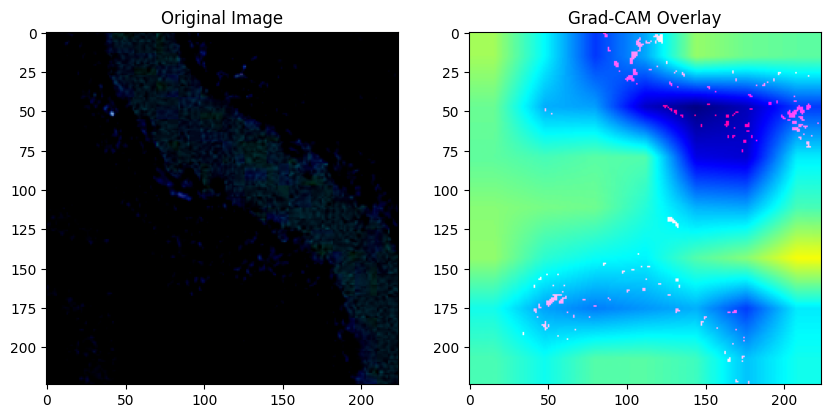

Epoch 10, Loss: 0.03170016787878693, Accuracy: 98.95%, Validation Loss: 0.03422077805214829, Validation Accuracy: 99.33%, Running time: 199.37824368476868


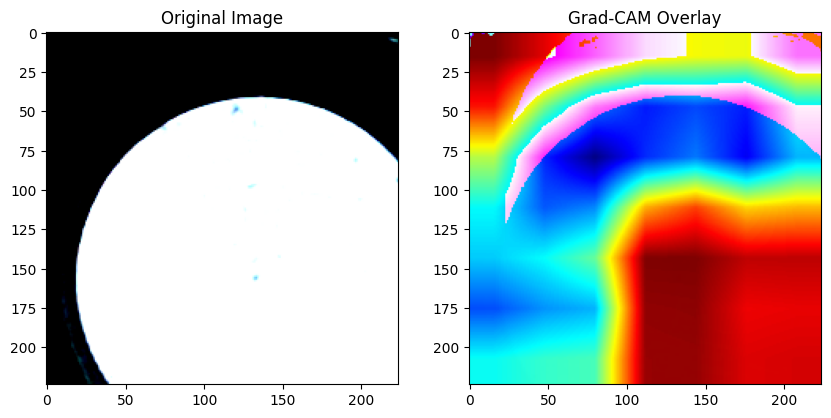

Epoch 11, Loss: 0.02322813965012551, Accuracy: 99.24%, Validation Loss: 0.09128469757905061, Validation Accuracy: 97.15%, Running time: 198.9852123260498


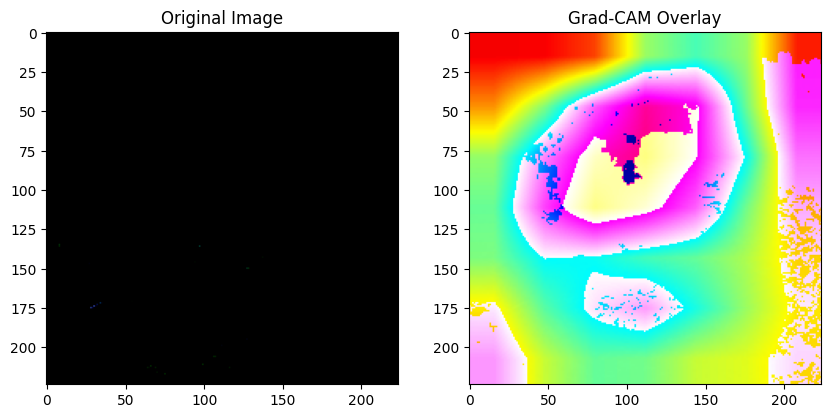

Epoch 12, Loss: 0.037497956890086705, Accuracy: 98.88%, Validation Loss: 0.05118900949265949, Validation Accuracy: 98.62%, Running time: 199.0132393836975


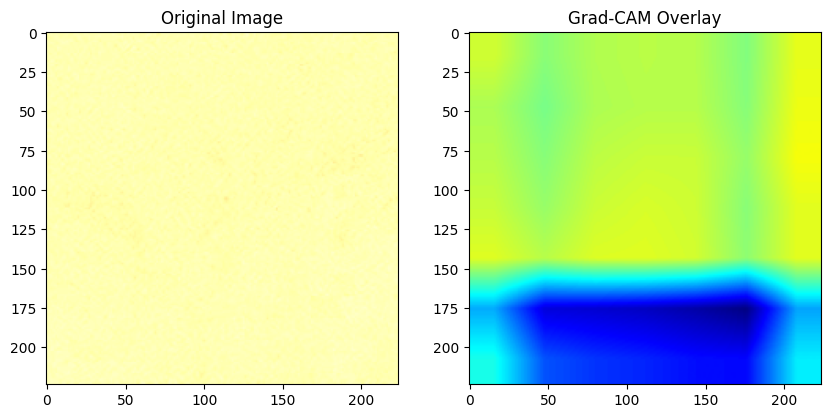

Epoch 13, Loss: 0.045138143681572325, Accuracy: 98.63%, Validation Loss: 0.024952230509811532, Validation Accuracy: 99.22%, Running time: 199.63449668884277


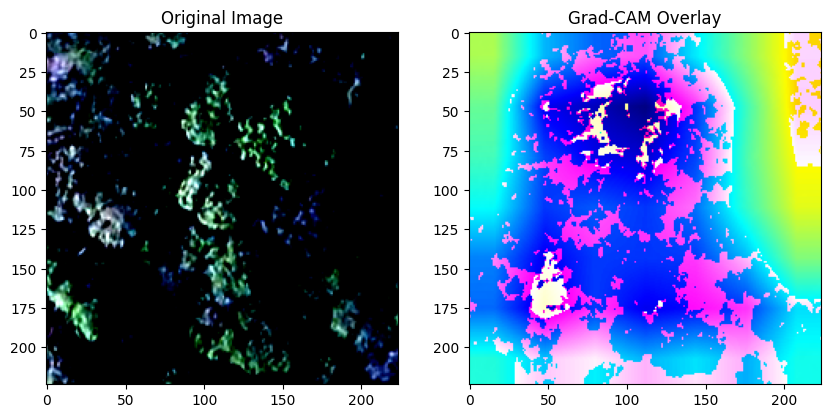

Epoch 14, Loss: 0.030487017822073918, Accuracy: 99.00%, Validation Loss: 0.02433305298517084, Validation Accuracy: 99.22%, Running time: 199.3476493358612


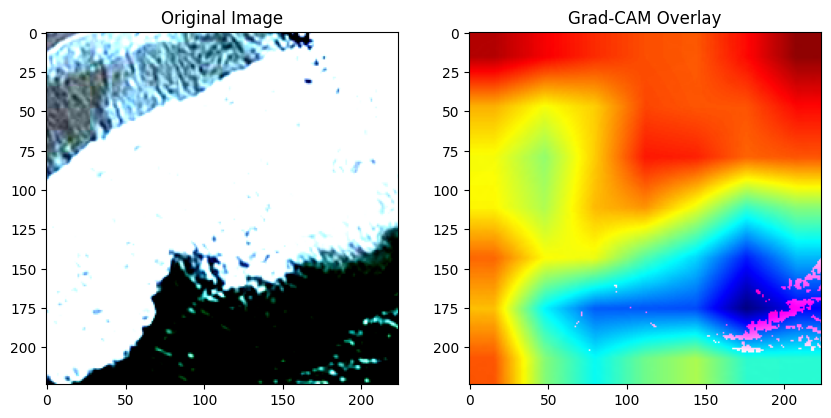

Epoch 15, Loss: 0.03375879479243971, Accuracy: 99.03%, Validation Loss: 0.03264863754597944, Validation Accuracy: 99.07%, Running time: 199.45963311195374


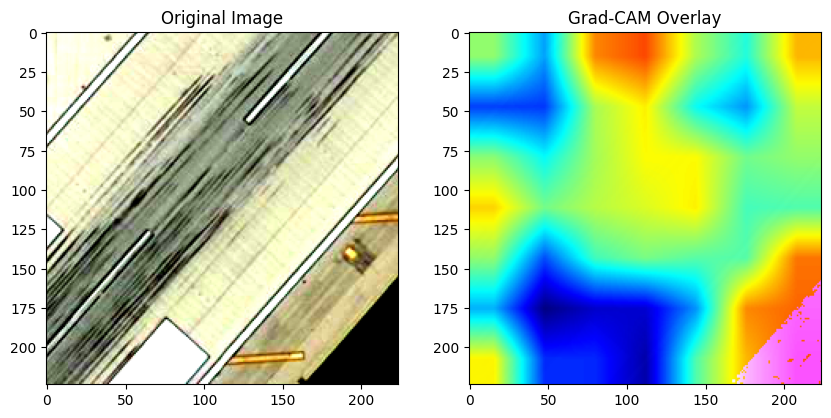

Epoch 16, Loss: 0.02053031604579555, Accuracy: 99.33%, Validation Loss: 0.03573455657390172, Validation Accuracy: 99.24%, Running time: 200.2084503173828


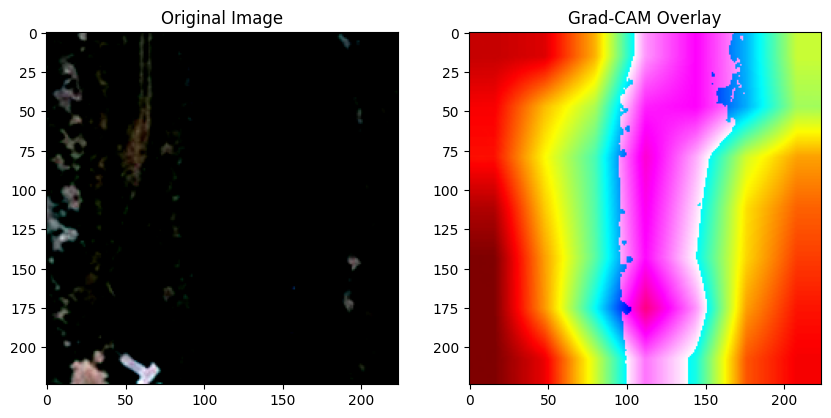

Epoch 17, Loss: 0.015103361225422135, Accuracy: 99.51%, Validation Loss: 0.01874180128365741, Validation Accuracy: 99.50%, Running time: 199.6574788093567


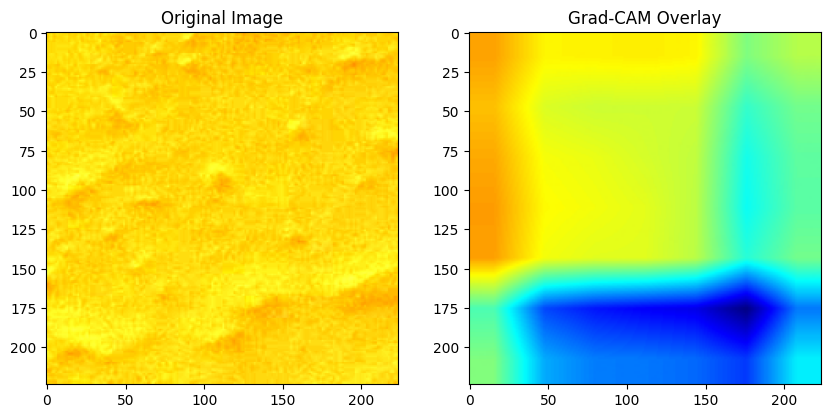

Epoch 18, Loss: 0.01485528700896947, Accuracy: 99.56%, Validation Loss: 0.03912661781456942, Validation Accuracy: 98.91%, Running time: 199.47338032722473


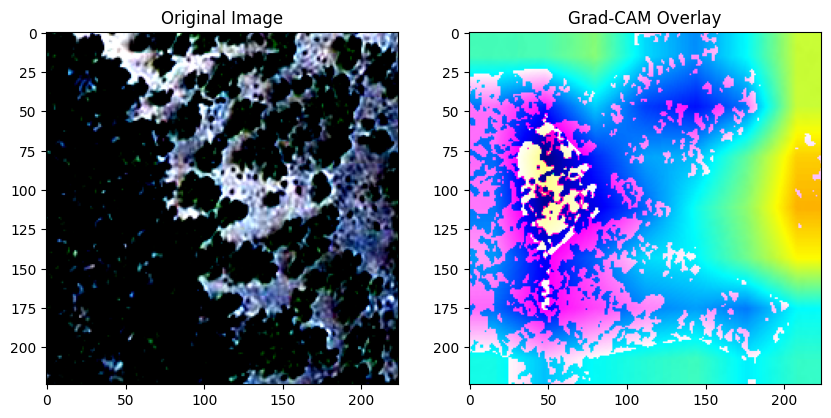

Epoch 19, Loss: 0.021669073730797378, Accuracy: 99.55%, Validation Loss: 0.030310982952483533, Validation Accuracy: 99.12%, Running time: 199.37322545051575


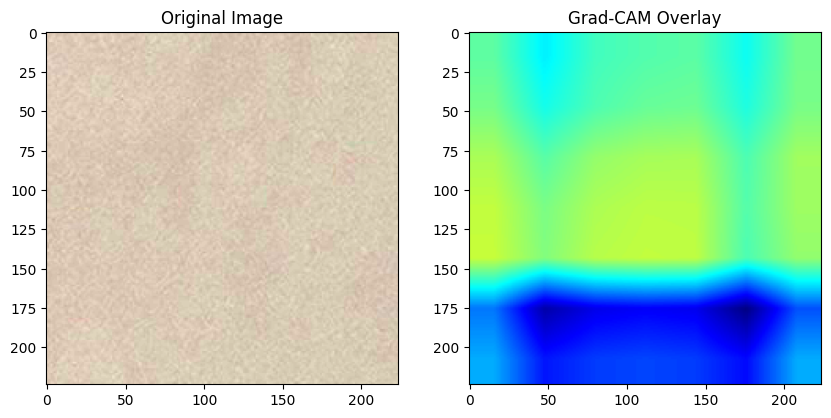

Epoch 20, Loss: 0.05459431172812204, Accuracy: 98.36%, Validation Loss: 0.10814969050415764, Validation Accuracy: 96.75%, Running time: 198.89078974723816


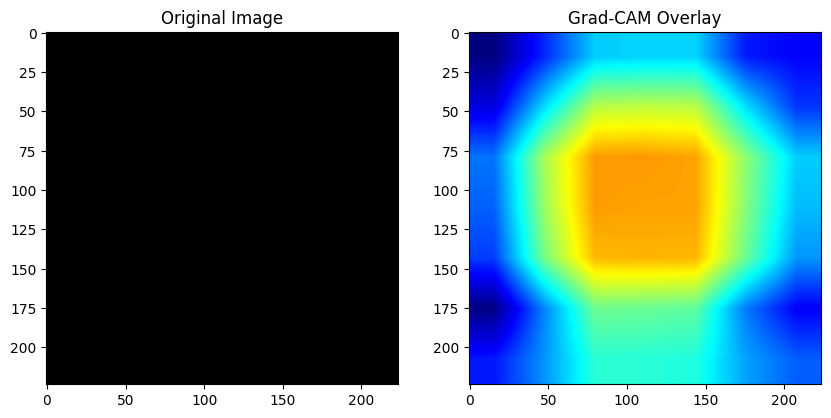

Epoch 21, Loss: 0.023943908156290876, Accuracy: 99.33%, Validation Loss: 0.02190277060237184, Validation Accuracy: 99.36%, Running time: 199.99670839309692


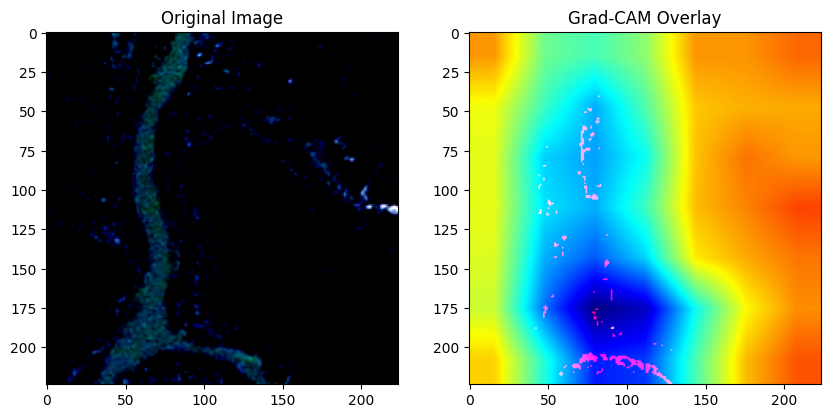

Epoch 22, Loss: 0.013949154192610499, Accuracy: 99.55%, Validation Loss: 0.033599432798589325, Validation Accuracy: 99.19%, Running time: 198.78833031654358


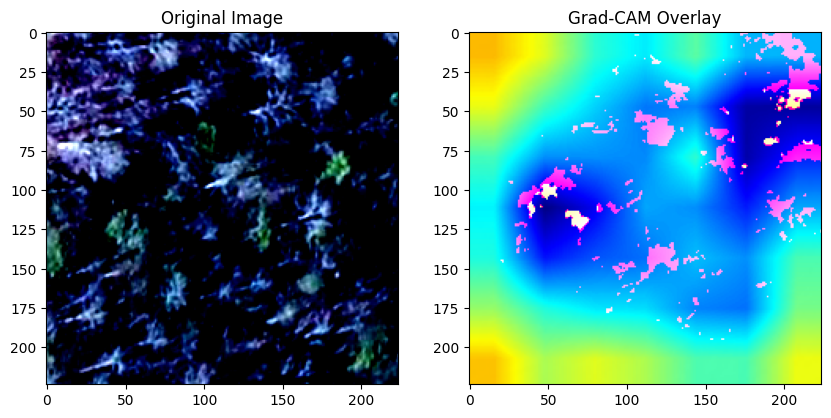

Early stopping!
Training stopped due to early stopping.


In [14]:
patience = 5
best_valid_loss = float('inf')
epochs_no_improve = 0
early_stopping = False

train_loss_list = []
train_accuracy_list = []
valid_loss_list = []
valid_accuracy_list = []

target_layer = model.features[-1]
gradcam = GradCAM(model, target_layer)

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    model.eval()
    valid_loss = 0.0
    valid_correct_predictions = 0
    valid_total_predictions = 0

    with torch.no_grad():
        for valid_inputs, valid_labels in valid_loader:
            valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)
            valid_outputs = model(valid_inputs)
            valid_loss += criterion(valid_outputs, valid_labels).item()

            _, valid_predicted = torch.max(valid_outputs, 1)
            valid_correct_predictions += (valid_predicted == valid_labels).sum().item()
            valid_total_predictions += valid_labels.size(0)

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions
    valid_loss = valid_loss / len(valid_loader)
    valid_accuracy = valid_correct_predictions / valid_total_predictions

    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    valid_loss_list.append(valid_loss)
    valid_accuracy_list.append(valid_accuracy)

    print(f"Epoch {epoch+1}, Loss: {train_loss}, Accuracy: {train_accuracy * 100:.2f}%, "
          f"Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy * 100:.2f}%, "
          f"Running time: {elapsed_time}")

    sample_inputs, sample_labels = next(iter(valid_loader))
    sample_inputs = sample_inputs.to(device)
    original_image = sample_inputs[0].permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

    cam = gradcam.generate_cam(sample_inputs[0].unsqueeze(0))  # Generate Grad-CAM
    overlay_image = visualize_gradcam(cam, original_image)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Overlay")
    plt.imshow(overlay_image)
    plt.show()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping!")
            early_stopping = True
            break

if early_stopping:
    print("Training stopped due to early stopping.")
else:
    print("Training completed all epochs.")
